<a href="https://colab.research.google.com/github/Gusmeira/Forecasting/blob/main/Forecast_Case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Description**



The case consists of an Excel file attached to this email (`Forecast Value`), containing data on values (`column Value`) attributed to certain countries (`column Country`), and these values vary over time (`column Month/Year`). The recorded values are from February 2022 to December 2023 (for each country).

From a business perspective, these values represent sales target achievement percentages.

For example: The above record indicates that the sales target for Colombia and Ecuador in February 2022 was 58%.

The objective of the case is basically: based on the recorded values from Feb 2022 to Dec 2023, **predict** what the value for Jan 2024 would be for each country.

___
# **Libs**

### pip install

In [ ]:
!pip install arch
!pip install pycaret

### Imports

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os

import plotly.graph_objects as go
from matplotlib import pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from arch.unitroot import ADF, KPSS, PhillipsPerron
import pycaret

___
# **Data Wrangling**

### Data Preparation

In [ ]:
# pd.DataFrame Creation
df = pd.read_excel('Forecast Value.xlsx')

# Temporal Data Wrangling
df['Month/Year'] = pd.to_datetime(df['Month/Year'])
df['Month/Year'] = df['Month/Year'].dt.to_period('M')
df.set_index('Month/Year', inplace=True)

# Filtering by country in distinct pd.DataFrames
countries = df['Country'].unique().tolist()
colombia_ecuador = df[df['Country'] == countries[0]]
peru = df[df['Country'] == countries[1]]
brasil = df[df['Country'] == countries[2]]
data_frames = [colombia_ecuador, peru, brasil]

# pd.Series
for serie in data_frames:
    del serie['Country']
colombia_ecuador = pd.Series(colombia_ecuador['Value'])
peru = pd.Series(peru['Value'])
brasil = pd.Series(brasil['Value'])

### Time Series Object

In [ ]:
class Forecast:
    def __init__(self, series:pd.Series,
                 train_test_split:int,
                 horizon:int, seasonal_period:int,
                 plot:bool=False) -> None:

        self.series = series
        self.train_test_split = train_test_split
        self.horizon = horizon-1
        self.seasonal_period = seasonal_period
        self.plot = plot

        if (self.train_test_split < self.horizon) and (self.train_test_split != 0):
            raise ValueError('train_test_split must be at least equal to horizon!')

        if self.train_test_split > 0:
            self.train = self.series.iloc[:-train_test_split].rename('Train')
            self.test = self.series.iloc[-train_test_split:].rename('Test')
            self.ligant = pd.concat([self.train[-1:], self.test[0:1]])
        else:
            self.train = self.series.rename('Train')
            self.test = self.series.iloc[-1:].rename('Test')

        self.stationarity = self.stationarity_type()

# ==============================================================================

    def plot_time_series(self):
        '''Internal Function.\n
        Plot the main time series with it's train and test properties'''
        self.fig, self.ax = plt.subplots(figsize=(7, 3.5))
        self.train.plot(ax=self.ax, legend=True, lw=3, color='k')
        if self.train_test_split > 0:
            self.test.plot(ax=self.ax, legend=False, lw=3, color='k')
            self.ax.axvline(x=self.train.index[-1], color='grey', linestyle='--', lw=1)
            self.ligant.plot(ax=self.ax, legend=False, lw=1.5, color='k', linestyle='--')
            self.ax.grid(True)

# ==============================================================================

    def stationarity_type(self, printing:bool=False, diff:int=0) -> None:
        '''Internal and External Function.\n
        It is used to determinate if train series is stationary or not.
        The parameter `printing` allows you to visualize results if set to True.
        Statistical methos used are:
        - ADF (Augmented Duck-Fuller)
        - KPSS (Kwiatkowski-Phillips-Schmidt-Shin)
        - PP (Pjillips-Perron)'''

        if diff > 0:
            self.train = self.train.diff(diff).dropna()

        try:
            method_stationary = ''
            method_non_stationary = ''
            stationarity_points = 0

            # Used for major
            result_adf = ADF(self.train)
            result_adf = result_adf.pvalue
            # Used for trends
            result_kpss = KPSS(self.train)
            result_kpss = result_kpss.pvalue
            # Used for autocerrelation
            result_pp = PhillipsPerron(self.train)
            result_pp = result_pp.pvalue

            if result_adf < 0.05:
                stationarity_points += 1
                method_stationary += 'ADF '
            else:
                method_non_stationary += 'ADF '

            if result_kpss > 0.05:
                stationarity_points += 1
                method_stationary += 'KPSS '
            else:
                method_non_stationary += 'KPSS '

            if result_pp < 0.05:
                stationarity_points += 1
                method_stationary += 'PP '
            else:
                method_non_stationary += 'PP '

            if stationarity_points >= 2:
                self.stationarity = 'stationary'
                self.stationarity_method = method_stationary.strip()
            else:
                self.stationarity = 'non-stationary'
                self.stationarity_method = method_non_stationary.strip()

            # Printing == True
            if printing:
                print(f'===== Stacionarity Test in {diff} diff =====')
                print('ADF p-value:', np.round(result_adf,4))
                print('KPSS p-value:', np.round(result_kpss,4))
                print('PP p-value:', np.round(result_pp,4))
                print(f'Result: {self.stationarity} ({self.stationarity_method})')

        except:
            self.stationarity = 'stationary'
            self.stationarity_method = 'inconclusive'

        return self.stationarity


# ==============================================================================

    def model_errors(self, prediction:pd.Series):
        '''Internal Function.\n
        It allows all train_test() methods to calculate errors.
        - Absolute errors:
            - Difference
            - MAE
            - RMSE
        - Percentage errors:
            - MAPE'''
        error = np.round(self.test[self.horizon]-prediction[-1],2)
        mae = np.round(np.abs(self.test[self.horizon]-prediction[-1]),2)
        rmse = np.round(np.sqrt((self.test[self.horizon]-prediction[-1])**2),2)
        mape = np.round(100*np.abs(self.test[self.horizon]-prediction[-1])/self.test[self.horizon],2)

        errors = {'error': error,
                  'mae': mae,
                  'rmse': rmse,
                  'mape': mape}

        return errors

# ==============================================================================

    def time_indexes(self, values:list, create_df:bool = True):
        '''Internal Function.\n
        It allows some methods to access the dates that will be predicted.'''
        self.time_index = pd.date_range(start=self.train.index[-1].to_timestamp(), periods=self.horizon+2, freq='MS')[1:]

        if create_df == True:
            df = pd.Series(values, index=self.time_index)
            return df

        return self.time_index

# ==============================================================================

    def acf_pacf(self):
        '''External Function.\n
        Plot Auto Correlation Function and Partial Auto Correlation Function'''
        fig, ax = plt.subplots(1,2, figsize=(10,3))
        sm.graphics.tsa.plot_acf(self.train, lags=self.seasonal_period, ax=ax[0])
        sm.graphics.tsa.plot_pacf(self.train, lags=self.seasonal_period, ax=ax[1])
        plt.show()

# ==============================================================================

    def plot_seasonal_decompose(self):
        '''External Function.\n
        Plot Seasonal Decomposition'''
        decomposition = seasonal_decompose(obj.train, model='additive', period=obj.seasonal_period)

        plt.subplots(4,1,figsize=(8.5,7))
        plt.subplot(4,1,1)
        decomposition.observed.dropna().plot(title='Observed');
        plt.subplot(4,1,2)
        decomposition.trend.dropna().plot(title='Trend');
        plt.subplot(4,1,3)
        decomposition.seasonal.dropna().plot(title='Seasonal');
        plt.subplot(4,1,4)
        decomposition.resid.dropna().plot(title='Residual');
        plt.tight_layout()

___
# **Forecasting Methods**

### ARIMA

In [ ]:
class ARIMA_Model:
    def __init__(self, forecaster:Forecast,
                 order=(1,1,1), seasonal_order=(0,0,0,12)) -> None:
        self.forecaster = forecaster
        self.time_series = forecaster.series
        self.train = forecaster.train
        self.test = forecaster.test
        self.horizon = forecaster.horizon
        self.order = order
        self.seasonal_order = seasonal_order

# ==============================================================================

    def train_test(self, return_full:bool=False):

        if (self.forecaster.train_test_split == 0):
            raise ValueError("For training and testing, train_test_split mustn't be 0")

        # Model Fitting
        model = ARIMA(
            endog=self.train,
            order=self.order,
            seasonal_order=self.seasonal_order)
        self.fitted_model = model.fit()
        self.arima_fittedvalues = self.fitted_model.fittedvalues.shift(-1).dropna()

        # Predictions
        self.prediction = self.fitted_model.predict(
            start=len(self.train),
            end=len(self.train) + self.horizon,
            typ='levels').rename(f'ARIMA {self.order}{self.seasonal_order}')

        # Saving the Errors
        errors = self.forecaster.model_errors(prediction=self.prediction)
        self.error = errors['error']
        self.mae = errors['mae']
        self.rmse = errors['rmse']
        self.mape = errors['mape']

        # Plotting the Results
        if self.forecaster.plot:
            print(f'Error: {np.round(self.mape,2)}%')
            self.forecaster.plot_time_series()
            self.arima_fittedvalues.plot(lw=1.5, color='#FF9941')
            self.prediction.plot(legend=True, grid=True, color='#FF9941')
            plt.scatter(self.prediction.index[-1],self.prediction[-1], color='#FF9941')
            plt.grid(True)
            plt.show()

        if return_full:
            self.forecaster.models['arima'] = pd.concat([self.train, self.prediction])
            return {'arima': pd.concat([self.train, self.prediction])}

        return {'arima': self.prediction[-self.horizon-1:]}

# ==============================================================================

    def predict(self):

        if (self.forecaster.train_test_split != 0):
            raise ValueError('For predictions, train_test_split must be 0')

        # Model Fitting
        model = ARIMA(
            endog=self.time_series,
            order=self.order,
            seasonal_order=self.seasonal_order)
        self.fitted_model = model.fit()
        self.arima_fittedvalues = self.fitted_model.fittedvalues.shift(-1).dropna()

        # Predictions
        self.prediction = self.fitted_model.predict(
        start=len(self.time_series),
        end=len(self.time_series) + self.horizon,
        typ='levels').rename(f'ARIMA {self.order}{self.seasonal_order}')

        # Plotting the Results
        if self.forecaster.plot:
            self.forecaster.plot_time_series()
            self.arima_fittedvalues.plot(lw=1.5, color='#FF9941')
            self.prediction.plot(legend=True, grid=True, color='#FF9941')
            plt.scatter(self.prediction.index[-1],self.prediction[-1], color='#FF9941')
            plt.grid(True)
            plt.show()

        return {'arima': self.prediction[-self.horizon-1:]}

### N-Beats

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self,
                 input_size: int = 12,
                 theta_size: int = 12+1,
                 horizon: int = 1,
                 n_neurons: int = 128,
                 n_layers: int = 4,
                 **kwargs):

        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]

        self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name='theta')

    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

# >>>>>>>>>>>>>>>>>>>>>>>>>> CLASS <<<<<<<<<<<<<<<<<<<<<<<<<<<<
class NBeats:
    def __init__(self,
                 forecaster: Forecast,
                 **kwargs) -> None:
        self.forecaster = forecaster
        self.horizon = forecaster.horizon+1

        self.input_size = self.forecaster.seasonal_period
        self.window_size = self.input_size
        self.theta_size = self.forecaster.seasonal_period+1
        self.n_neurons = 128
        self.n_layers = 4
        self.n_stacks = 1
        self.n_epochs = 100

        window = self.preprocessing()
        if self.forecaster.train_test_split > 0:
            self.train = window[0][:-self.forecaster.train_test_split]
            self.train_label = window[1][:-self.forecaster.train_test_split]
            self.test = window[0][-self.forecaster.train_test_split:]
            self.test_label = window[1][-self.forecaster.train_test_split:]
        else:
            self.train = window[0]
            self.train_label = window[1]
            self.test = window[0][-1:]
            self.test_label = window[1][-1:]

# ==============================================================================

    def preprocessing(self):
        x = self.forecaster.series.values
        window_size = self.window_size
        horizon = self.horizon

        def get_labelled_windows(x, horizon=horizon):
            return x[:, :-horizon], x[:, -horizon:]

        window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
        window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
        window_array = x[window_indexes]

        windows, labels = get_labelled_windows(x=window_array, horizon=horizon)

        return windows, labels

# ==============================================================================

    def create_Model_checkpoint(model_name, save_path='model_experiments'):
        return tf.keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(save_path, model_name),
            verbose=0,
            save_best_only=True)

# ==============================================================================

    def neural_networks(self):
        # 1. Setup NBEATS Block layer
        nbeats_block_layer = NBeatsBlock(name="InitialBlock",
                                         input_size = self.input_size,
                                         theta_size = self.theta_size,
                                         horizon = self.horizon,
                                         n_neurons = self.n_neurons,
                                         n_layers = self.n_layers)

        # 2. Create input to stacks
        stack_input = tf.keras.layers.Input(shape=(self.input_size,), name="stack_input")

        # 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
        backcast, forecast = nbeats_block_layer(stack_input)
        # Add in subtraction residual link
        residuals = tf.keras.layers.subtract([stack_input, backcast], name=f"subtract_00")

        # 4. Create stacks of blocks
        for i, _ in enumerate(range(self.n_stacks-1)): # first stack is already creted in (3)

        # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
            backcast, block_forecast = NBeatsBlock(
                input_size=self.input_size,
                theta_size=self.theta_size,
                horizon=self.horizon,
                n_neurons=self.n_neurons,
                n_layers=self.n_layers,
                name=f"NBeatsBlock_{i}"
            )(residuals) # pass it in residuals (the backcast)

            # 6. Create the double residual stacking
            residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}")
            forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")

        # 7. Put the stack model together
        self.model = tf.keras.Model(inputs=stack_input,
                                    outputs=forecast,
                                    name="model_NBEATS")

        # 8. Compile with MAE loss and Adam optimizer
        self.model.compile(loss="mae",
                            optimizer=tf.keras.optimizers.Adam(0.001),
                            metrics=["mae", "mse"])

        # 9. Fit the self.model with EarlyStopping and ReduceLROnPlateau callbacks
        self.model.fit(self.train,
                       self.train_label,
                       epochs=self.n_epochs,
                       validation_data=(self.test, self.test_label),
                       verbose=0,
                       callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, restore_best_weights=True),
                                  tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=50, verbose=0)])

        return self.model

# ==============================================================================

    def train_test(self):

        if (self.forecaster.train_test_split == 0):
            raise ValueError("For training and testing, train_test_split mustn't be 0")

        self.neural_networks()

        self.prediction = self.model.predict(tf.expand_dims(self.train[-1], axis=0))
        self.prediction = tf.squeeze(self.prediction).numpy()
        self.prediction = self.forecaster.time_indexes(values=self.prediction).rename('N-Beats')

        # Saving the Errors
        errors = self.forecaster.model_errors(prediction=self.prediction)
        self.error = errors['error']
        self.mae = errors['mae']
        self.rmse = errors['rmse']
        self.mape = errors['mape']

        # Plotting the Results
        if self.forecaster.plot:
            print(f'Error: {np.round(self.mape,2)}%')
            self.forecaster.plot_time_series()
            self.prediction.plot(color='#db2e2e')
            self.forecaster.train[-self.input_size:].plot(legend=True, color='#db2e2e', label='N-Beats')
            plt.scatter(self.prediction.index[-1],self.prediction[-1], color='#db2e2e')
            plt.grid(True)
            plt.show()

        return {'n_beats': self.prediction}

# ==============================================================================

    def predict(self):

        if (self.forecaster.train_test_split != 0):
            raise ValueError('For predictions, train_test_split must be 0')

        self.neural_networks()

        self.prediction = self.model.predict(tf.expand_dims(self.train[-1], axis=0))
        self.prediction = tf.squeeze(self.prediction).numpy()
        self.prediction = self.forecaster.time_indexes(values=self.prediction).rename('N-Beats')

        # Plotting the Results
        if self.forecaster.plot:
            self.forecaster.plot_time_series()
            self.prediction.plot(color='#db2e2e')
            self.forecaster.train[-self.input_size:].plot(legend=True, color='#db2e2e', label='N-Beats')
            plt.scatter(self.prediction.index[-1],self.prediction[-1], color='#db2e2e')
            plt.grid(True)
            plt.show()

        return {'n_beats': self.prediction}

___
# **Results**

#### Cross Validation Function

In [ ]:
def cross_validation(serie:pd.Series, arima_order=(1,1,1)):
    '''Cross Validation'''
    results = pd.DataFrame()
    for period in [3,6,12]:
        for split in [1,2,3,4]:
            obj = Forecast(series=serie, train_test_split=split, horizon=1, seasonal_period=period, plot=False)

            arima = ARIMA_Model(forecaster=obj, order=arima_order, seasonal_order=(0,0,0,period))
            arima.train_test()

            n_beats = NBeats(forecaster=obj)
            n_beats.train_test()

            iter_results = pd.DataFrame({
                'seasonal_period': [period],
                'train_test_split': [split],
                'arima_error': [arima.mape],
                'n_beats_error': [n_beats.mape],
            })

            results = pd.concat([results, iter_results], axis=0)

    results = results.sort_values(by=['arima_error', 'n_beats_error'], ascending=True)
    results = results.reset_index(drop=True)

    return results

___
## **Colombia/Ecuador**

### EDA

In [ ]:
obj = Forecast(series=colombia_ecuador, train_test_split=0, horizon=1, seasonal_period=11, plot=True)

Decomposição Sazonal

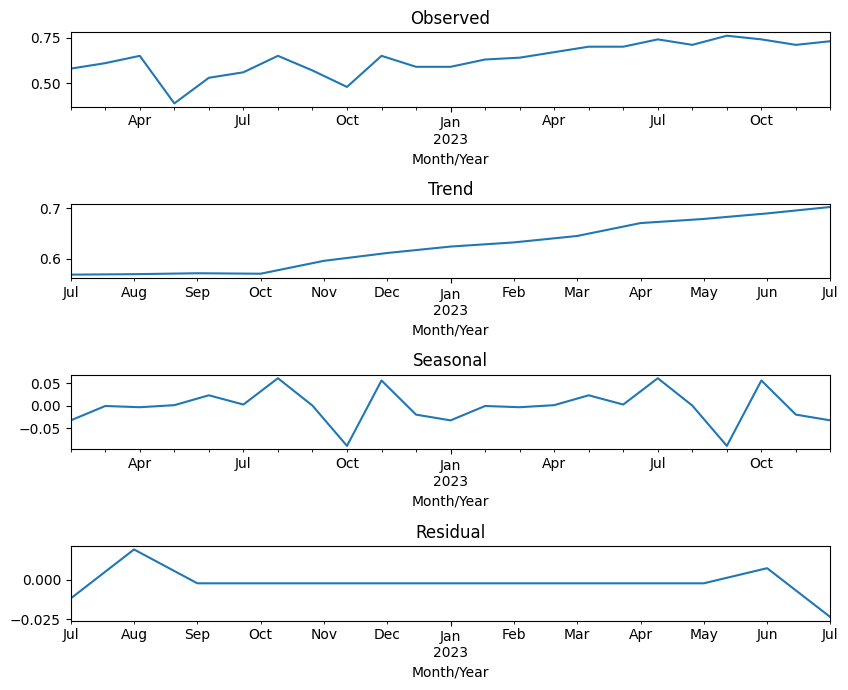

In [ ]:
obj.plot_seasonal_decompose()

Funções de Autocorrelação

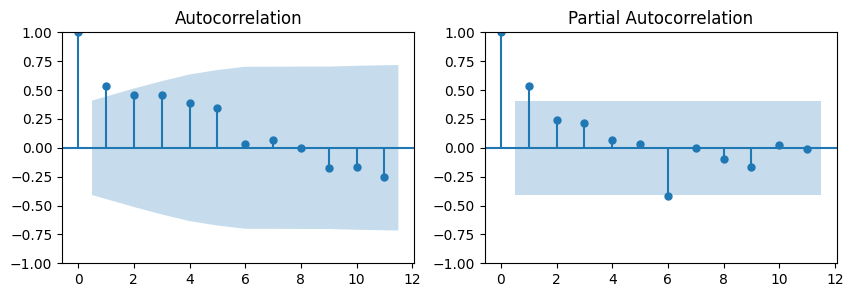

In [ ]:
obj.acf_pacf()

Estacionariedade

In [ ]:
obj.stationarity_type(printing=True, diff=0)
print()
obj.stationarity_type(printing=True, diff=1)
print()
obj.stationarity_type(printing=True, diff=2)

===== Stacionarity Test in 0 diff =====
ADF p-value: 0.7558
KPSS p-value: 0.0259
PP p-value: 0.1082
Result: non-stationary (ADF KPSS PP)

===== Stacionarity Test in 1 diff =====
ADF p-value: 0.2891
KPSS p-value: 0.2042
PP p-value: 0.0
Result: stationary (KPSS PP)

===== Stacionarity Test in 2 diff =====
ADF p-value: 0.0049
KPSS p-value: 0.9547
PP p-value: 0.0
Result: stationary (ADF KPSS PP)


'stationary'

### Forecasting

#### Cross Validation

In [ ]:
results = cross_validation(colombia_ecuador, arima_order=(1,2,1))
display(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


,seasonal_period,train_test_split,arima_error,n_beats_error
0,3,1,0.06,0.03
1,12,1,0.06,0.82
2,6,1,0.06,0.90
3,3,3,1.68,3.38
4,6,3,1.68,6.06
5,12,3,1.68,7.06
6,3,4,3.72,5.74
7,6,4,3.72,6.52
8,12,4,3.72,10.77
9,6,2,6.93,0.38


#### Forecasting

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


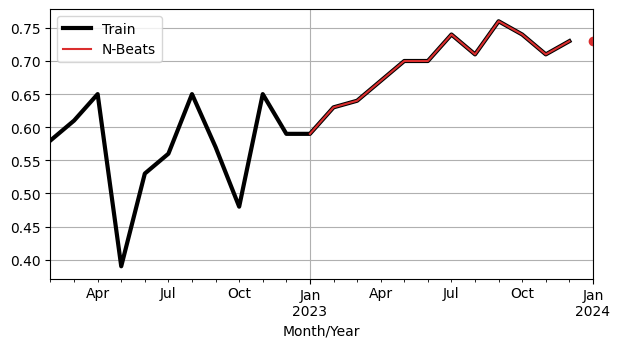

{'n_beats': 2024-01-01    0.73079
 Freq: MS, Name: N-Beats, dtype: float32}

In [ ]:
obj = Forecast(series=colombia_ecuador, train_test_split=0, horizon=1, seasonal_period=12, plot=True)
n_beats = NBeats(forecaster=obj)
n_beats.predict()

___
## **Peru**

### EDA

In [ ]:
obj = Forecast(series=peru, train_test_split=0, horizon=1, seasonal_period=11, plot=True)

Decomposição Sazonal

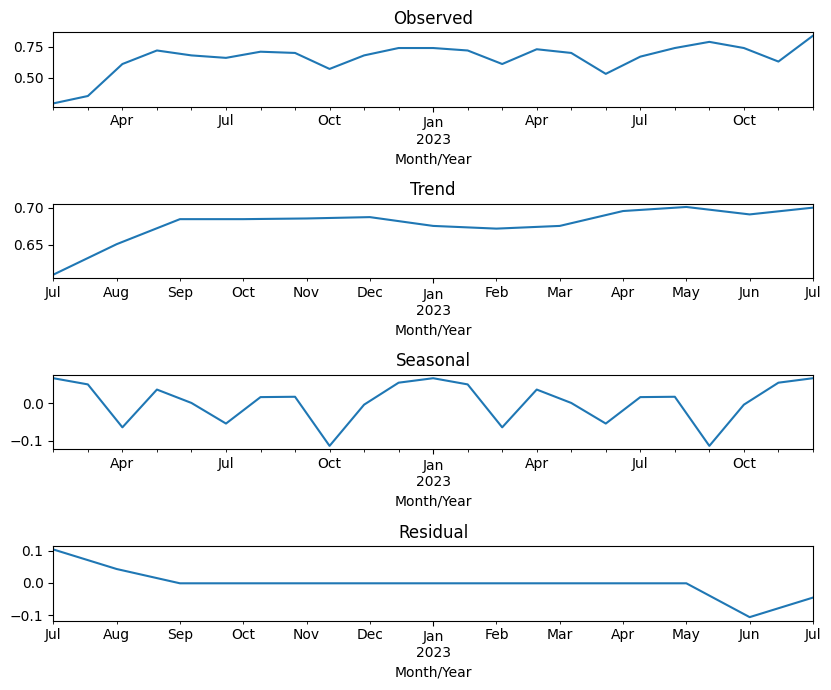

In [ ]:
obj.plot_seasonal_decompose()

Funções de Autocorrelação

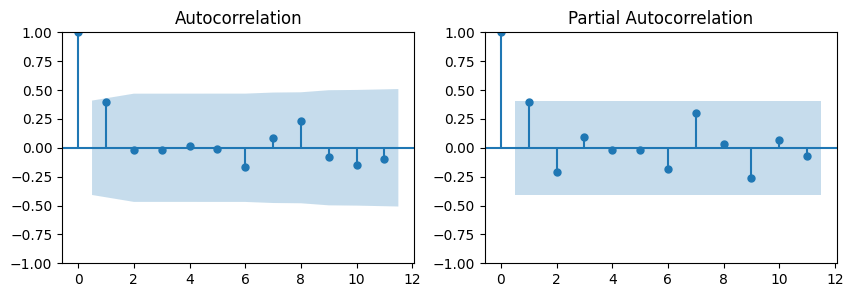

In [ ]:
obj.acf_pacf()

Estacionariedade

In [ ]:
obj.stationarity_type(printing=True, diff=0)
print()
obj.stationarity_type(printing=True, diff=1)
print()
obj.stationarity_type(printing=True, diff=2)

===== Stacionarity Test in 0 diff =====
ADF p-value: 0.0024
KPSS p-value: 0.0435
PP p-value: 0.0002
Result: stationary (ADF PP)

===== Stacionarity Test in 1 diff =====
ADF p-value: 0.7405
KPSS p-value: 0.4888
PP p-value: 0.0003
Result: stationary (KPSS PP)

===== Stacionarity Test in 2 diff =====
ADF p-value: 0.4953
KPSS p-value: 0.559
PP p-value: 0.0001
Result: stationary (KPSS PP)


'stationary'

### Forecasting

#### Cross Validation

In [ ]:
results = cross_validation(peru, arima_order=(1,0,1))
display(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


,seasonal_period,train_test_split,arima_error,n_beats_error
0,12,2,1.01,13.54
1,6,2,1.01,15.59
2,3,2,1.01,18.28
3,6,3,7.52,1.14
4,12,3,7.52,1.54
5,3,3,7.52,3.37
6,12,4,18.42,3.49
7,3,4,18.42,6.29
8,6,4,18.42,9.61
9,6,1,23.45,0.07


#### Forecasting

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


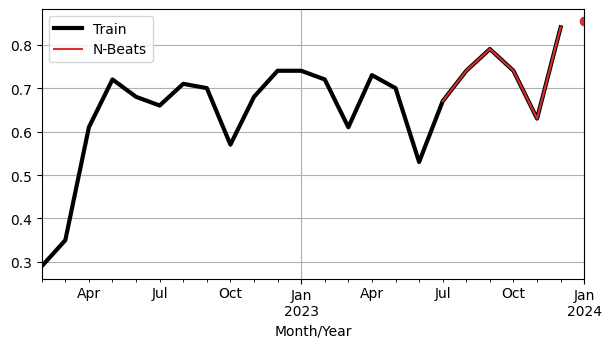

{'n_beats': 2024-01-01    0.853931
 Freq: MS, Name: N-Beats, dtype: float32}

In [ ]:
obj = Forecast(series=peru, train_test_split=0, horizon=1, seasonal_period=6, plot=True)
n_beats = NBeats(forecaster=obj)
n_beats.predict()

___
## **Brazil**

### EDA

In [ ]:
obj = Forecast(series=brasil, train_test_split=0, horizon=1, seasonal_period=11, plot=True)

Decomposição Sazonal

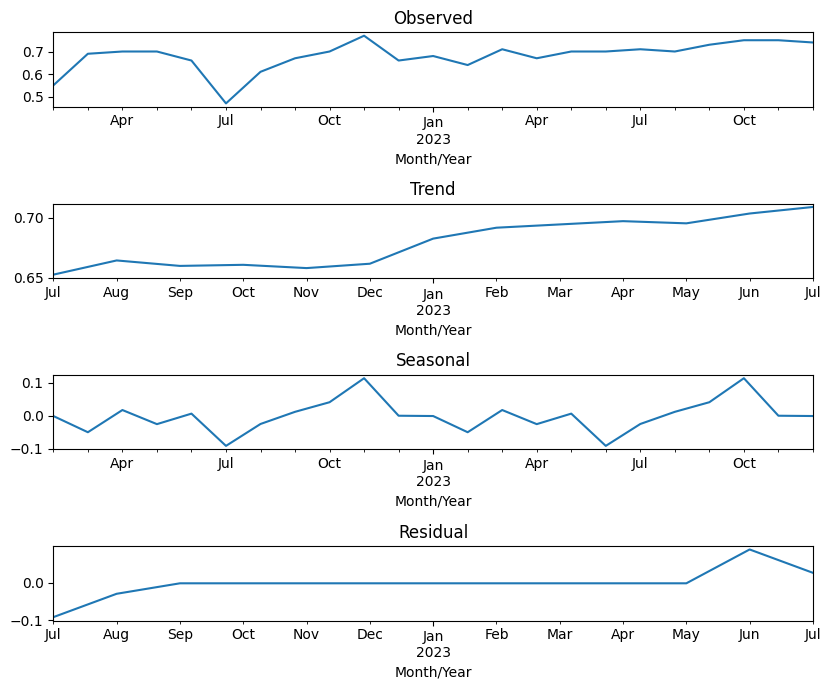

In [ ]:
obj.plot_seasonal_decompose()

Funções de Autocorrelação

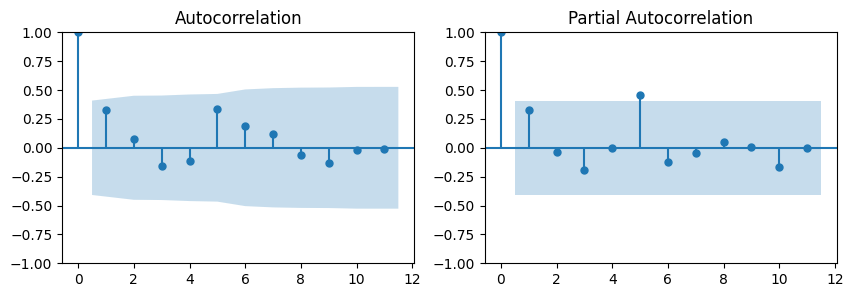

In [ ]:
obj.acf_pacf()

Estacionariedade

In [ ]:
obj.stationarity_type(printing=True, diff=0)
print()
obj.stationarity_type(printing=True, diff=1)
print()
obj.stationarity_type(printing=True, diff=2)

===== Stacionarity Test in 0 diff =====
ADF p-value: 0.999
KPSS p-value: 0.0439
PP p-value: 0.0106
Result: non-stationary (ADF KPSS)

===== Stacionarity Test in 1 diff =====
ADF p-value: 0.0
KPSS p-value: 0.7851
PP p-value: 0.0
Result: stationary (ADF KPSS PP)

===== Stacionarity Test in 2 diff =====
ADF p-value: 0.438
KPSS p-value: 0.7667
PP p-value: 0.0
Result: stationary (KPSS PP)


'stationary'

### Forecasting

#### Cross Validation

In [ ]:
results = cross_validation(peru, arima_order=(5,1,0))
display(results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


,seasonal_period,train_test_split,arima_error,n_beats_error
0,3,3,8.36,2.71
1,6,3,8.36,2.97
2,12,3,8.36,5.91
3,3,2,9.20,1.87
4,6,2,9.20,3.17
5,12,2,9.20,10.32
6,3,4,18.08,4.07
7,12,4,18.08,5.44
8,6,4,18.08,7.38
9,6,1,18.97,0.14


#### Forecasting

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


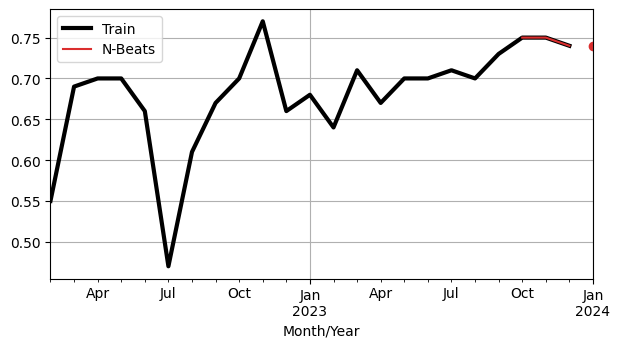

{'n_beats': 2024-01-01    0.739354
 Freq: MS, Name: N-Beats, dtype: float32}

In [ ]:
obj = Forecast(series=brasil, train_test_split=0, horizon=1, seasonal_period=3, plot=True)
n_beats = NBeats(forecaster=obj)
n_beats.predict()

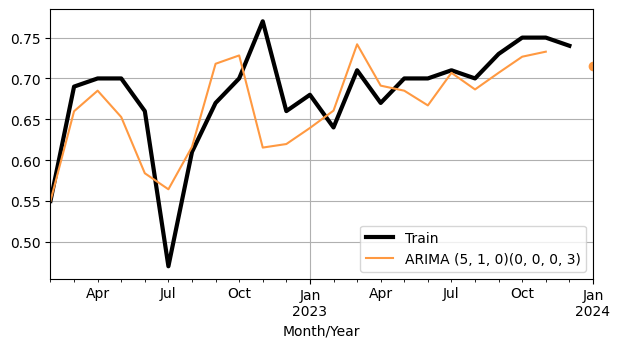

{'arima': 2024-01    0.715049
 Freq: M, Name: ARIMA (5, 1, 0)(0, 0, 0, 3), dtype: float64}

In [ ]:
arima = ARIMA_Model(forecaster=obj, order=(5,1,0), seasonal_order=(0,0,0,3))
arima.predict()

For this specific case, it would be interesting to apply the first principle of CRISP-DM, which involves both data understanding and business understanding, to evaluate which approach would be more appropriate. Since we don't have all the necessary information, a balanced combination of both (50%-50%) would be a sensible approach.